# Computer Vision Lab Project - JKU - 2021
### Team B0
  
Team Members: Dominik Heindl, Philipp Eberstaller, Carson Wittwer  

In [5]:
from abc import ABC, abstractmethod
import glob
import json
import os
import sys
from skimage.metrics import structural_similarity
from time import time, gmtime, strftime
from typing import Tuple, Dict, List

import cv2
import matplotlib.pyplot as plt
import numpy as np
import spectral as sp
from scipy.stats import chi2

import torch
from torchvision.io import write_video
from torchvision.transforms import functional, ToTensor, Lambda, Compose
from torchvision.utils import save_image

import utils as ut

from clahe import clahe

#### Loading Data Utilities

In [6]:
def load_homographies(input_dir: str):
    """
    Finds all homographies.json files recursively in a given input directory.

    Args:
        input_dir: Input directory which contains .json files

    Returns:
        A dictionary mapping the folder names to dictionaries with the homographies
        Each dictionary is structured as follows:
            {Folder Name (e.g. "valid-1-0"): {File Name (e.g. 0-B01): List[homographies]}}}
    """
    sorted_homographies = sorted(glob.glob(
        os.path.join(input_dir, '**', '*ies.json'),
        recursive=True
    ))

    homographies = {}

    for file in sorted_homographies:
        folders, file_name = os.path.split(file)
        folder_name = os.path.basename(folders)

        homographies[folder_name] = json.loads(open(file, 'r').read())

    return homographies

def load_numpy_array(file_path: str) -> np.ndarray:
    """Loads a saved and compressed numpy array"""
    arr = np.load(file_path)
    return arr['arr_0']

def read_images(
        input_dir: str,
        mask: np.ndarray,
        integrated_only: bool = True
) -> Tuple[Dict[str, Dict[str, Dict[str, np.ndarray]]], Dict[str, Dict[str, Dict[str, np.ndarray]]]]:
    """
    Finds all .png files recursively in a given input directory. The images are loaded,
    a mask is applied to filter unwanted regions of the images and the images get
    warped based on the provided homographies.
    With this dictionary structure it can be assured that the images of one
    image set always go together.

    Args:
        input_dir: Input directory which contains .png images
        mask: Filter to mask out unwanted regions of all images at the same position
        integrated_only: Whether to load only the integrated

    Returns:
        A tuple containing 2 dictionaries for the original and warped images.
        Each dictionary is structured as follows:
            {Folder Name (e.g. "valid-1-0"): {File Set Number (e.g. 0): {File Name (e.g. 0-B01): Image as array}}}
    """
    input_dir = os.path.abspath(input_dir)

    if integrated_only:
        sorted_files = sorted(glob.glob(
            os.path.join(input_dir, '**', '*-int_image.png'),
            recursive=True
        ))
    else:
        sorted_files = sorted(glob.glob(
            os.path.join(input_dir, '**', '*.png'),
            recursive=True
        ))

        homographies = load_homographies(input_dir)

    original_images = {}
    warped_images = {}

    for file in sorted_files:
        folders, file_name = os.path.split(file)

        if not integrated_only:
            if any(x not in file_name for x in ('mask', 'int_image', 'mask_image')):
                continue

        file_name = file_name.split('.')[0]
        folder_name = os.path.basename(folders)
        file_set = file_name.split('-')[0]

        if folder_name not in original_images and folder_name not in warped_images:
                original_images[folder_name] = {}
                warped_images[folder_name] = {}

        if file_set not in original_images[folder_name] and file_set not in warped_images[folder_name]:
            original_images[folder_name].update({file_set: {}})
            warped_images[folder_name].update({file_set: {}})

        img = cv2.imread(file)

        if not integrated_only:
            if folder_name not in warped_images:
                warped_images[folder_name] = {}

            if file_set not  in warped_images[folder_name]:
                warped_images[folder_name].update({file_set: {}})

            w, h, _ = img.shape
            img = cv2.bitwise_and(img,img,mask=mask) #apply the mask to remove the timestamp

            homography = np.array(homographies[folder_name][file_name]) #get homography

            warped_img = cv2.warpPerspective(img, homography, (w,h)) #warp the image using the given homography
            warped_images[folder_name][file_set].update({file_name: warped_img})

        original_images[folder_name][file_set].update({file_name: img}) #save the original

    return original_images, warped_images

def read_anomaly_masks(
        input_dir: str,
        integrated_only: bool = True
) -> Tuple[Dict[str, Dict[str, Dict[str, np.ndarray]]], Dict[str, Dict[str, Dict[str, np.ndarray]]]]:
    """
    Finds all .png files recursively in a given input directory. The images are loaded,
    a mask is applied to filter unwanted regions of the images and the images get
    warped based on the provided homographies.
    With this dictionary structure it can be assured that the images of one
    image set always go together.

    Args:
        input_dir: Input directory which contains .png images
        mask: Filter to mask out unwanted regions of all images at the same position
        integrated_only: Whether to load only the integrated

    Returns:
        A tuple containing 2 dictionaries for the original and warped images.
        Each dictionary is structured as follows:
            {Folder Name (e.g. "valid-1-0"): {File Set Number (e.g. 0): {File Name (e.g. 0-B01): Image as array}}}
    """
    input_dir = os.path.abspath(input_dir)

    if integrated_only:
        sorted_files = sorted(glob.glob(
            os.path.join(input_dir, '**', '*-anomaly_mask.png'),
            recursive=True
        ))
    else:
        sorted_files = sorted(glob.glob(
            os.path.join(input_dir, '**', '*.png'),
            recursive=True
        ))

    original_images = {}

    for file in sorted_files:
        folders, file_name = os.path.split(file)

        if not integrated_only:
            if any(x not in file_name for x in ('mask', 'int_image', 'mask_image')):
                continue

        file_name = file_name.split('.')[0]
        folder_name = os.path.basename(folders)
        file_set = file_name.split('-')[0]

        if folder_name not in original_images:
                original_images[folder_name] = {}
                

        if file_set not in original_images[folder_name]:
            original_images[folder_name].update({file_set: {}})
            

        img = cv2.imread(file)

        original_images[folder_name][file_set].update({file_name: img}) #save the original

    return original_images

def read_image_masks(
        input_dir: str,
        integrated_only: bool = True
) -> Tuple[Dict[str, Dict[str, Dict[str, np.ndarray]]], Dict[str, Dict[str, Dict[str, np.ndarray]]]]:
    """
    Finds all .png files recursively in a given input directory. The images are loaded,
    a mask is applied to filter unwanted regions of the images and the images get
    warped based on the provided homographies.
    With this dictionary structure it can be assured that the images of one
    image set always go together.

    Args:
        input_dir: Input directory which contains .png images
        mask: Filter to mask out unwanted regions of all images at the same position
        integrated_only: Whether to load only the integrated

    Returns:
        A tuple containing 2 dictionaries for the original and warped images.
        Each dictionary is structured as follows:
            {Folder Name (e.g. "valid-1-0"): {File Set Number (e.g. 0): {File Name (e.g. 0-B01): Image as array}}}
    """
    input_dir = os.path.abspath(input_dir)

    if integrated_only:
        sorted_files = sorted(glob.glob(
            os.path.join(input_dir, '**', '*-mask_image.png'),
            recursive=True
        ))
    else:
        sorted_files = sorted(glob.glob(
            os.path.join(input_dir, '**', '*.png'),
            recursive=True
        ))

    original_images = {}

    for file in sorted_files:
        folders, file_name = os.path.split(file)

        if not integrated_only:
            if any(x not in file_name for x in ('mask', 'int_image', 'mask_image')):
                continue

        file_name = file_name.split('.')[0]
        folder_name = os.path.basename(folders)
        file_set = file_name.split('-')[0]

        if folder_name not in original_images:
                original_images[folder_name] = {}
                

        if file_set not in original_images[folder_name]:
            original_images[folder_name].update({file_set: {}})
            

        img = cv2.imread(file)

        original_images[folder_name][file_set].update({file_name: img}) #save the original

    return original_images

def read_numpy_masks(
        input_dir: str,
        integrated_only: bool = True
) -> Tuple[Dict[str, Dict[str, Dict[str, np.ndarray]]], Dict[str, Dict[str, Dict[str, np.ndarray]]]]:
    """
    Finds all .png files recursively in a given input directory. The images are loaded,
    a mask is applied to filter unwanted regions of the images and the images get
    warped based on the provided homographies.
    With this dictionary structure it can be assured that the images of one
    image set always go together.

    Args:
        input_dir: Input directory which contains .png images
        mask: Filter to mask out unwanted regions of all images at the same position
        integrated_only: Whether to load only the integrated

    Returns:
        A tuple containing 2 dictionaries for the original and warped images.
        Each dictionary is structured as follows:
            {Folder Name (e.g. "valid-1-0"): {File Set Number (e.g. 0): {File Name (e.g. 0-B01): Image as array}}}
    """
    input_dir = os.path.abspath(input_dir)

    if integrated_only:
        sorted_files = sorted(glob.glob(
            os.path.join(input_dir, '**', '*-anomaly_array.npz'),
            recursive=True
        ))
    else:
        sorted_files = sorted(glob.glob(
            os.path.join(input_dir, '**', '*.png'),
            recursive=True
        ))

    original_images = {}

    for file in sorted_files:
        folders, file_name = os.path.split(file)

        if not integrated_only:
            if any(x not in file_name for x in ('mask', 'int_image', 'mask_image')):
                continue

        file_name = file_name.split('.')[0]
        folder_name = os.path.basename(folders)
        file_set = file_name.split('-')[0]

        if folder_name not in original_images:
                original_images[folder_name] = {}
                

        if file_set not in original_images[folder_name]:
            original_images[folder_name].update({file_set: {}})
            

        img = load_numpy_array(file)

        original_images[folder_name][file_set].update({file_name: img}) #save the original
    
    return original_images



#### Other Utilities


In [7]:
def display_images(images, figsize=None, resize_dim=(200, 200)):
    if figsize: row, col = figsize
    else: row, col = 1,1
        
    fig, axs = plt.subplots(row, col, figsize=figsize)
    if row>1 or col>1: axs = axs.flatten()
    else: axs = [axs]
    fig.set_figwidth(20)
    fig.set_figheight(15)
    
    for img, ax in zip(images, axs):
        ax.imshow(cv2.resize(img, resize_dim), interpolation='nearest')
        
    plt.show()

def integrate(images: np.ndarray):

    integrated_images = []
    mask_images = []
    background_images = []
    """
    This is going through all the sets of images,True
    where images[0] represents 10 images in a numpy array
    """
    for i in range(len(images)): 
        integral = np.zeros((images[0].shape[1:]), np.float64)
        mask = np.zeros((images[0].shape[1:]), np.float64)
        mask = mask[:,:,0]
        mask_ = np.copy(mask)

        for j in range(len(images[i])):
            integral += images[i][j]
            
            height, width, _ = images[i][j].shape
            for x in range(height):
                for y in range(width):
                    if all(images[i][j][x,y] == [0,0,0]):
                        mask[x,y] += 1
        
        x,y = mask.shape
        for n in range(x):
            for m in range(y):
                if mask[n,m] == 0:
                    mask_[n,m] = 1
                else:
                    mask_[n,m] = 0
        
        #cv2.cvtColor(np.float32(mask_),cv2.COLOR_GRAY2BGR)

        mask_images.append(mask_)
        integral /= len(images[i]) 
        integral=cv2.normalize(integral, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        integrated_images.append(integral)

    return integrated_images , mask_images

def color_check(image: np.ndarray):
    height, width = image.shape[:2]
    cc = np.zeros(image.shape, np.float64)
    for y,x in zip(range(height),range(width)):
        if all(image[x,y] != [0,0,0]):
            cc[x,y]=[0,0,0]
    return np.array(cc)

def crop_image(image):
    grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    _,thresh = cv2.threshold(grayscale,0,255,cv2.THRESH_OTSU)

    bbox = cv2.boundingRect(thresh)
    x,y,w,h = bbox
    
    return x,y,w,h

## Anomaly Detection

I think it is good if we use a proper base class for the anomaly detection, this should ensure a unified interface which can be used at any point in our pipeline. Basically any algorithm implementation / class should have the method `anomaly_mask` which should return a mask where outliers are marked with 1 and other pixels remain 0.

In [8]:
class AnomalyDetection(ABC):
    def __init__(self, img: np.ndarray):
        self.img = img

    @abstractmethod
    def anomaly_mask(self) -> np.ndarray:
        """
        Takes whatever is necessary from the current object to generate an anomaly
        mask. The mask has the same height and width as the input image, anomalies are
        marked as 1, everything als with 0.
        """
        pass

### Reed-Xiaoli Detector
This anomaly detection algorithm is the baseline, which should not be used. Nevertheless it is good to have it implemented for comparisons.

In [9]:
class ReedXiaoliAnomaly(AnomalyDetection):
    def __init__(
            self,
            img: np.ndarray,
            conf_coef: float = 0.999,
            verbose: bool = False
    ):
        super().__init__(img)
        self.conf_coef = conf_coef
        self.verbose = verbose
        self.D_rx = None
        self.mask = None

    def _rxd(self):
        """
        Implementation of the Reed-Xiaoli detector. Calculates a score for each pixel as the
        Mahalanobis distance between the pixel and the background.

        Args:
            img: Image in the shape Height x Width x 3

        Returns:
            Numpy array with the Mahalanobis distance of each pixel with shape Height x Width of the input image
        """
        h, w, c = self.img.shape

        # Calculate Mean Vector
        mean_vec = np.mean(img, axis=(0, 1))

        # Calculate Covariance Matrix
        img_tmp = img.copy()
        img_tmp = img_tmp.astype('float32') - mean_vec
        img_tmp = img_tmp.reshape(-1, 3)
        cov_mat = (img_tmp.T @ img_tmp) / (img_tmp.shape[0] - 1)

        # Initialize Result Matrix
        D_rx = np.zeros((h,w))

        # Calculate Mahalanobis distance
        for i in range(h):
            for j in range(w):
                r = img[i,j]
                r_normal = r - mean_vec
                D_rx[i,j] = r_normal.T @ np.linalg.inv(cov_mat) @ r_normal

        return D_rx

    def anomaly_mask(self) -> np.ndarray:
        """
        Calculates a threshold for the values of the RX-detector in order to find
        only the most extreme anomalies which have a higher RX-score than conf_coef %
        of the values in the array. All values below this threshold are set to 0.
        If verbose is True, then the cumulative probability density of the rxd_array is
        printed alongside the returned mask.

        Returns:
            Anomaly mask where anomalies are 0, everything else is 0
        """
        self.D_rx = self._rxd()
        rxd_arr = self.D_rx.copy()
        rxd_sorted = np.sort(rxd_arr.flatten())
        prob = 1. * np.arange(len(rxd_sorted)) / (len(rxd_sorted) - 1)

        threshold_idx = np.argwhere(prob > self.conf_coef)[0][0]
        threshold = rxd_sorted[threshold_idx]

        mask = np.where(rxd_arr > threshold, 1, 0)
        # mask = rxd_arr > threshold
        # rxd_arr[mask] = 1
        # rxd_arr[~mask] = 0

        self.mask = mask

        if self.verbose:
            fig = plt.figure(figsize=(15,7))
            ax1 = fig.add_subplot(121)
            ax1.plot(rxd_sorted, prob)
            ax1.title.set_text("CDF of RX-Values")
            ax1.set_xlabel("RX Value")
            ax1.set_ylabel("Cumulative Probability")

            ax2 = fig.add_subplot(122)
            ax2.imshow(rxd_arr)
            ax2.title.set_text("Anomaly Mask")

        return self.mask

### Residual Approach

Originally this should be an implementation from `Reducing Anomaly Detection in Images to Detection in Noise` by Davy et al. The implementation is heavily influenced from this [GitHub Repository](https://github.com/whynotw/reducing_anomaly_detection), however by pure chance I stumbled across the fact that a burred version of the residual image is already looking promising for detection outliers. <br>
A disadvantage is that this algorithm takes ~1 min. per image to create the anomaly mask!

In [10]:
class ResidualAnomaly(AnomalyDetection):
    def __init__(
            self,
            img: np.ndarray,
            filter_size: int = 7,
            stride: int = 3,
            number_k: int = 5,
            threshold_intensity: int = 9
    ):
        super().__init__(img)
        if filter_size % 2 == 0:
            print("size of filter %d should be odd number" % filter_size)
        self.filter_size = filter_size
        self.stride = stride
        self.k = number_k
        self.threshold_intensity = threshold_intensity

        self.image_origin = img
        h, w, _ = img.shape

        h_remain = (h - filter_size) % stride
        w_remain = (w - filter_size) % stride
        self.image_origin = self.image_origin[:h - h_remain, :w - w_remain, :]

        self.h, self.w, _ = self.image_origin.shape
        self.h_red = (self.h - self.filter_size) // self.stride + 1
        self.w_red  = (self.w - self.filter_size) // self.stride + 1
        self.dim_data = 3 * self.filter_size ** 2
        self.img_acc = np.zeros((self.h, self.w, 3), dtype=np.float32)
        self.pixel_count = np.zeros((self.h, self.w), dtype=np.uint8)

        tmp_idx = np.arange(0, self.w_red * self.stride, self.stride, dtype=np.uint16)
        self.x0_data = np.stack((tmp_idx, ) * self.h_red)
        self.x1_data = self.x0_data+self.filter_size

        tmp_idx = np.arange(0, self.h_red * self.stride, self.stride, dtype=np.uint16)
        self.y0_data = np.stack((tmp_idx, ) * self.w_red).T
        self.y1_data = self.y0_data+self.filter_size
        self.knn = cv2.ml.KNearest_create()

        self.mask = None

    def _create_patches(self):
        """
        Divides the given image into pathes with size filter_size x filter_size.
        The filter is then moves forward for stride pixels. All patches are saved
        in the data object for the knn algorithm.

        Returns:
            None
        """
        self.data_total  = np.empty((self.h_red, self.w_red, self.dim_data), dtype=np.uint8)
        self.label_total = np.empty((self.h_red, self.w_red, 1), dtype=np.float32)

        count = 0
        for j in range(0, self.h_red):
            for i in range(0, self.w_red):
                x0 = i * self.stride
                x1 = x0 + self.filter_size
                y0 = j * self.stride
                y1 = y0 + self.filter_size
                self.data_total[j, i, :] = self.image_origin[y0:y1, x0:x1, :].reshape(-1)
                self.label_total[j, i, 0] = count
                count += 1

    def _get_knn(self):
        """
        Performs a knn algorithm on the previously calculated patches. This should
        ensure that anomalies are true anomalies and not part of some bigger pattern

        Returns:
            None
        """
        tmp_data = self.data_total.reshape((-1, self.dim_data)).astype(np.float32)

        self.knn.train(
            tmp_data,
            cv2.ml.ROW_SAMPLE,
            self.label_total.reshape(-1,1)
        )

        _, _, neighbours, distances = self.knn.findNearest(
            tmp_data,
            self.filter_size ** 2 + self.k
        )
        neighbours = neighbours.astype(np.int64)

        return neighbours, distances

    def _get_self_similar_estimate(self):
        """
        Creates a "self-similar" version of each image patch which is later used
        to create the residual image. The average values of the neighbour patches
        are divided from the current patch.

        Returns:
            None
        """
        neighbours,distances = self._get_knn()

        count = 0
        for j in range(0, self.h_red):
            for i in range(0, self.w_red):
                patch = np.zeros((self.filter_size, self.filter_size, 3), dtype=np.float32)
                x0 = self.stride * i
                x1 = x0 + self.filter_size
                y0 = self.stride * j
                y1 = y0 + self.filter_size

                partition = 1e-7
                effective = -1

                for k in range(len(neighbours)):
                    n = neighbours[count][k]
                    j_neighbour = n // self.w_red
                    i_neighbour = n % self.w_red

                    d = distances[count][k]

                    x0_n = self.stride * i_neighbour
                    x1_n = x0_n + self.filter_size
                    y0_n = self.stride * j_neighbour
                    y1_n = y0_n + self.filter_size

                    if x0 > x1_n or x1 < x0_n or y0 > y1_n or y1 < y0_n:
                        effective += 1
                    else:
                        continue

                    if effective == 0:
                        d0 = d

                    if effective >= self.k:
                        break

                    d -= d0
                    factor = np.exp(-d/self.dim_data)

                    if factor > 2**-8:
                        patch += factor * (
                            self.data_total[j_neighbour,i_neighbour,:]
                                .reshape((self.filter_size, self.filter_size, 3))
                        )
                        partition += factor

                self.img_acc[y0:y1, x0:x1, :] += patch / partition
                self.pixel_count[y0:y1, x0:x1] += 1
                count += 1

        self.img_red = np.uint8(self.img_acc / np.stack((self.pixel_count,) * 3, axis=-1))

    def anomaly_mask(self):
        """
        Calculates the residual image -> original image - self similar version of it.
        Then apply a GaussianBlus which removes weak outlier signals. The blurred image
        is then filtered for the top outlier value > some threshold.

        Returns:
            Anomaly mask where anomalies are 0, everything else is 0
        """
        self._create_patches()
        self._get_self_similar_estimate()
        tmp_residual = np.uint8(
            np.sum(
                np.abs(
                    np.int16(self.img_red) - np.int16(self.image_origin)
                ),
                axis=-1
            ) / 3
        )

        tmp_blurred = cv2.GaussianBlur(
            tmp_residual,
            (self.filter_size * 2 + 1,) * 2,
            0
        )

        # mask = np.where(tmp_blurred >= self.threshold_intensity, 1, 0)
        # self.mask = mask

        return tmp_blurred

## Bounding Boxes

### Add given BB

In [12]:
def add_bounding_boxes(
        img: np.ndarray,
        gtlabels: List[List[int]],
        rgb_color: Tuple[int] = (0, 0, 255),
        thickness: int = 5
) -> np.ndarray:
    """
    Adds the given bounding boxes to an image. These bounding boxes are
    only aligned for the center image!

    Args:
        img: Image to which bounding boxes should be added
        gtlabels: Bounding boxes from a labels.json file
        rgb_color: Tuple representing the RGB color of the box
        thickness: Thickness of the box line

    Returns:
        Image with an overlayed bounding boxes
    """
    img_processed = img.copy()
    for bb in gtlabels:
        x, y, w, h = bb
        img_processed = cv2.rectangle(
            img=img_processed,
            pt1=(x,y),
            pt2=(x+w, y+h),
            color=rgb_color,
            thickness=thickness
        )

    return img_processed

### Create new BB from anomaly mask

In [13]:
def is_close(cnt1,cnt2, max_dist=30):
    row1,row2 = cnt1.shape[0],cnt2.shape[0]
    for i in range(row1):
        for j in range(row2):
            dist = np.linalg.norm(cnt1[i]-cnt2[j])
            if abs(dist) < max_dist:
                return True
            elif i==row1-1 and j==row2-1:
                return False

def combine_contours(contours):
    n = len(contours)
    status = np.zeros((n,1))
    
    for i,cnt1 in enumerate(contours):
        x = i    
        if i != n-1:
            for j,cnt2 in enumerate(contours[i+1:]):
                x = x+1
                dist = is_close(cnt1,cnt2)
                if dist:
                    val = min(status[i],status[x])
                    status[x] = status[i] = val
                else:
                    if status[x]==status[i]:
                        status[x] = i+1

    unified = []
    maximum = int(status.max())+1
    for i in range(maximum):
        pos = np.where(status==i)[0]
        if pos.size != 0:
            cont = np.vstack(contours[i] for i in pos)
            hull = cv2.convexHull(cont)
            unified.append(hull)
                
    return unified

def area_filled(contour,mask):
    
    contour_area=np.zeros_like(mask)
    cv2.drawContours(contour_area, [contour], -1, 1, -1)
    mask_area=contour_area[mask.astype(bool)].sum()

    return mask_area.sum()

In [14]:
def get_bounding_boxes(mask, min_area=125):
    
    contours = cv2.findContours(mask.astype(np.uint8), mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)[0]
    
    if not len(contours):
        detected_anomalies_bb = np.zeros((0,4))
        
        return detected_anomalies_bb, contours

    combined = contours   
    #combined = combine_contours(contours)
    combined = [c for c in combined if not area_filled(c,mask)<min_area]
    
    if not len(combined):
        detected_anomalies_bb = np.zeros((0,4))
        return detected_anomalies_bb, combined
    
    detected_anomalies_bb = np.stack([cv2.boundingRect(c) for c in combined])
    
    return detected_anomalies_bb, combined

### Evaluation

In [382]:
MASK = 'data/mask.png'
IMAGE_FOLDER = 'data/validation/valid-1-0/'

mask = cv2.imread(MASK,0)
homographies = json.loads(open(IMAGE_FOLDER+'homographies.json','r').read())

#images = []

orig_images = []
warped_images = []

for root, dirs, files in os.walk(IMAGE_FOLDER):
    for file in files:
        #print(file)
        if file.endswith('.png'):
            img = cv2.imread(os.path.join(root,file))
            w,h,_ = img.shape
            orig_images.append(img)#save the original
            
            c0=img[:,:,0].copy()
            img[:,:,0]=img[:,:,2]
            img[:,:,1]=img[:,:,1]
            img[:,:,2]=c0
            
            res = cv2.bitwise_and(img,img,mask=mask) #apply the mask to remove the timestamp
            

            w,h,_ = img.shape
            name = file.replace('.png','')
            M = np.array(homographies[name]) #get homography

            res = cv2.warpPerspective(res, M, (w,h)) #warp the image using the given homography
            warped_images.append(res)

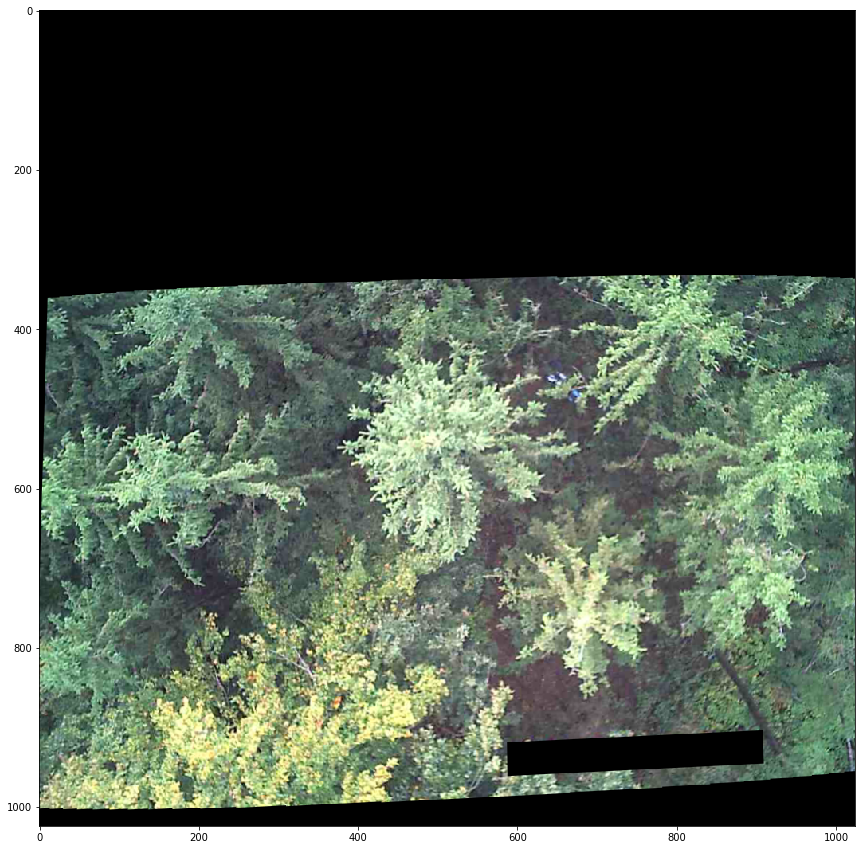

In [385]:

plt.figure(figsize = (15,15))
plt.imshow(warped_images[7])
plt.show()   

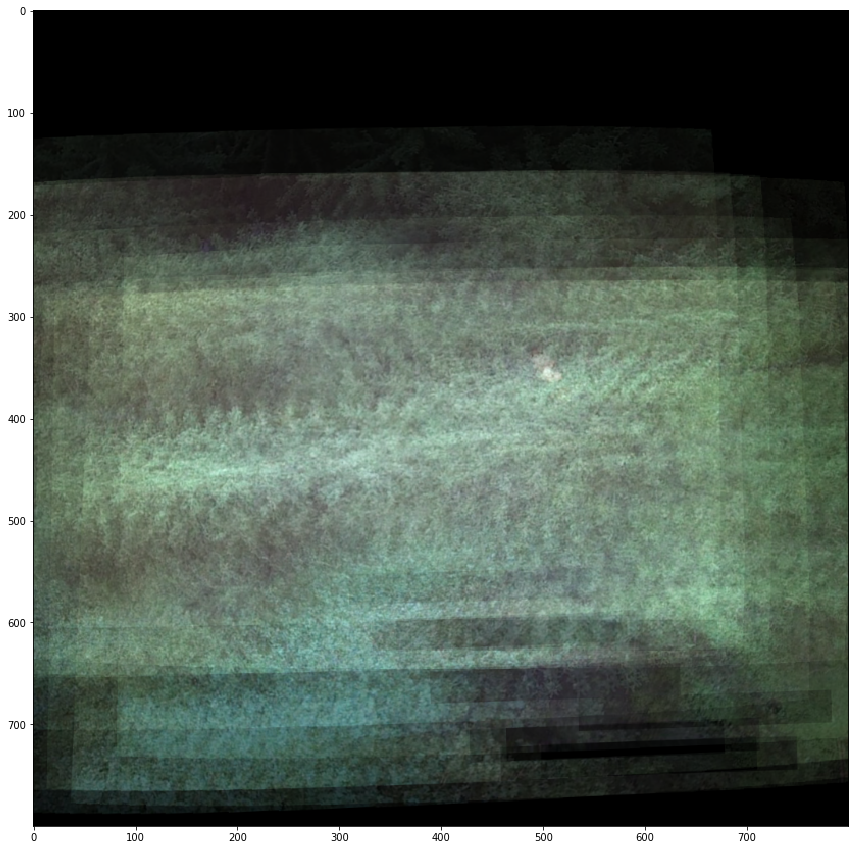

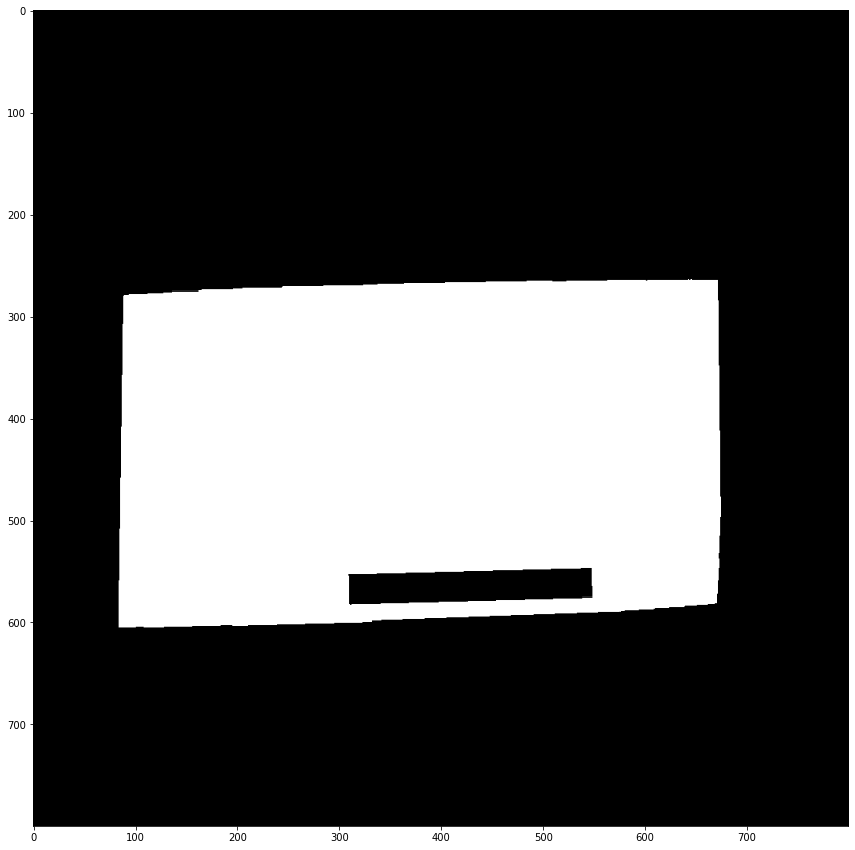

In [386]:
integrated_images, mask_images = integrate(np.array([gray_images[30:40]]))

int_img = [integrated_images[0]]

m_img = [cv2.cvtColor(np.float32(mask_images[0]),cv2.COLOR_GRAY2BGR)]

display_images(np.array(int_img), resize_dim=(800,800))
display_images(np.array(m_img), resize_dim=(800,800))

In [ ]:
#visualizing just the blue color
for im in val_middle_imgs:
    plt.imshow(im[:,:,0]/(im.sum(axis=2)+1),cmap="gray")
    plt.show()

C:\Users\phili\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


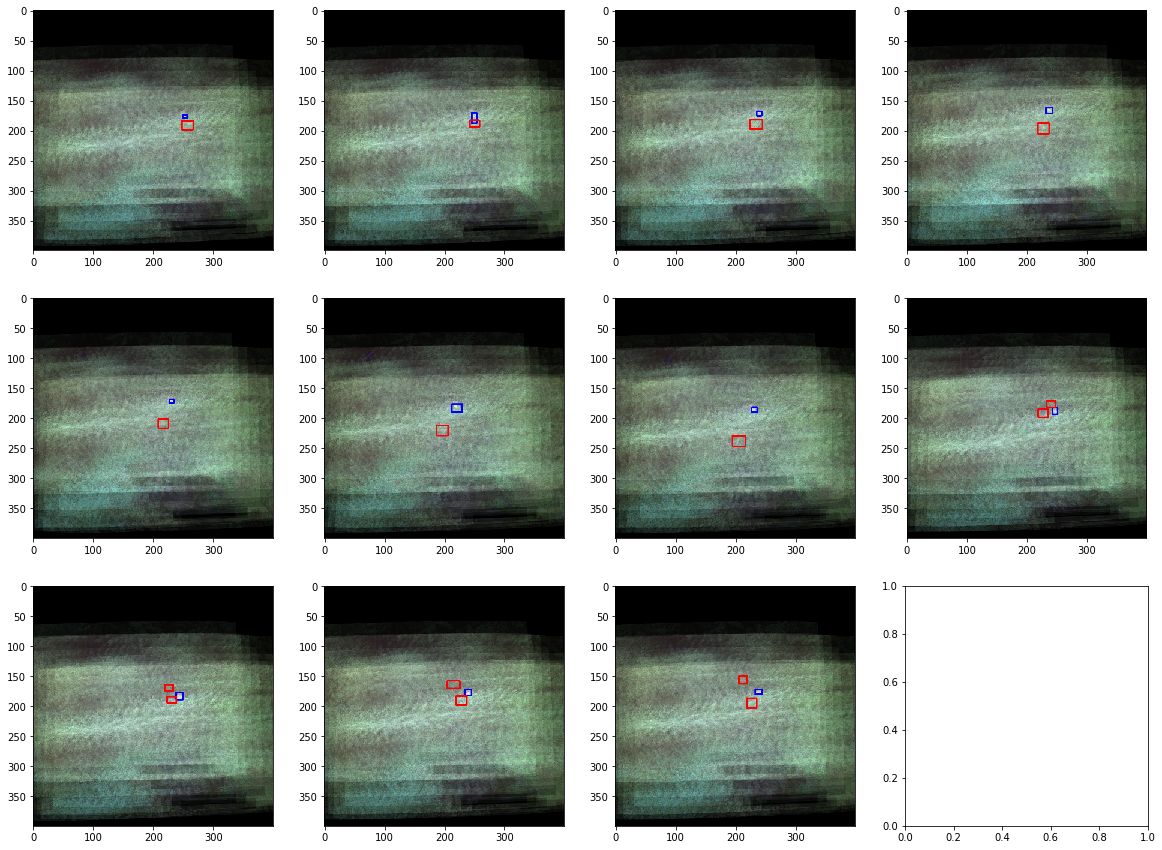

In [392]:
BBs=[]
for i in range(len(val_middle_anamalies)):
    BBs.append(get_bounding_boxes(val_middle_anamalies[i])[0])

images_result = []
for z in range(len(BBs)):
    tmp = val_middle_imgs[z].copy()
    add_bounding_boxes(tmp, BBs[z])
    images_result.append(add_bounding_boxes(tmp, labels[img_key_list[z]], rgb_color = (255, 0, 0)))
    
display_images(np.array(images_result), figsize=(3,4), resize_dim=(400,400))

In [393]:
print(len(BBs))

11


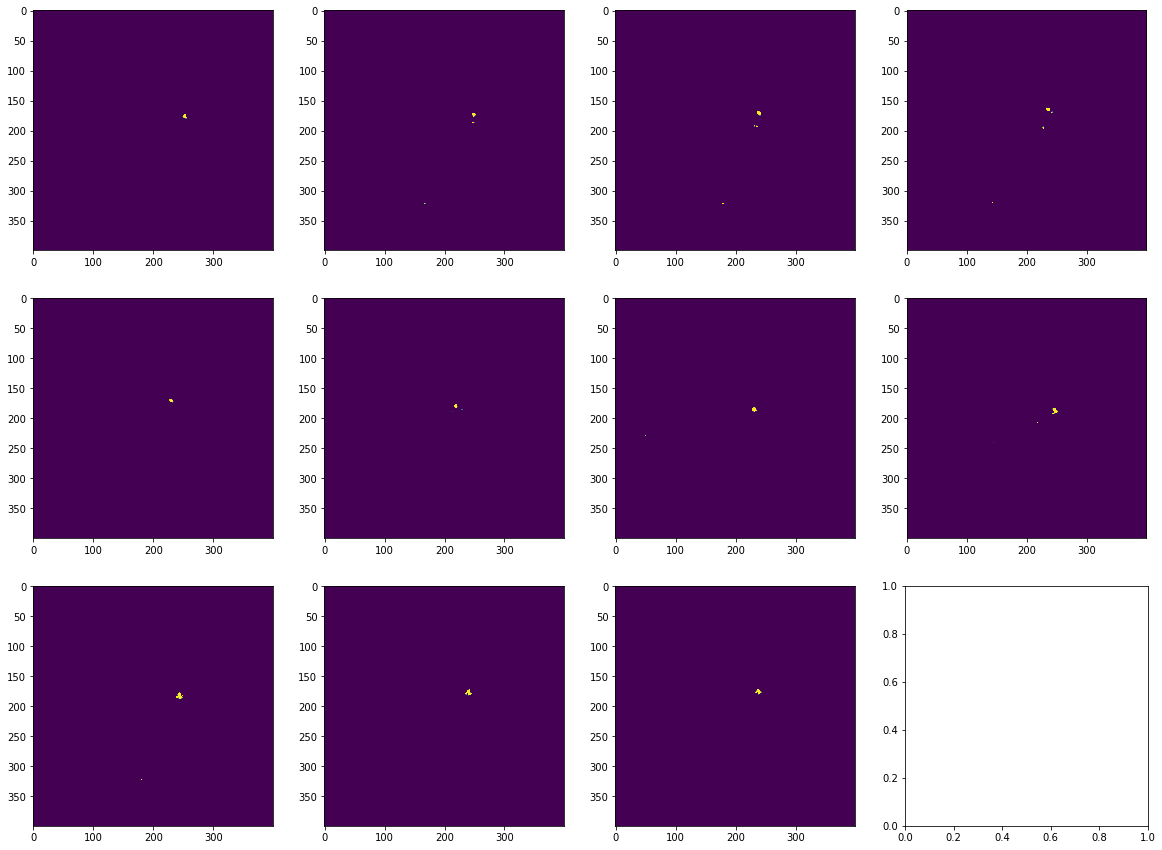

In [394]:
display_images(val_middle_anamalies, figsize=(3,4), resize_dim=(400,400))

## Working Locally 

Working on using the temporal data

In [5]:
def get_background_median(images):
    return np.median(images,axis=0).astype(np.uint8)

def get_background_mean(images):
    return np.mean(images,axis=0).astype(np.uint8)

In [6]:
def fixColor(image):
    return(cv2.cvtColor(image, cv2.COLOR_GRAY2BGR))


In [4]:
def preprocess(images: list):
    tensorizer = ToTensor()

    brightness_factor = 0.3
    contrast_factor = 4
    bri_cont_transform = Compose([
        Lambda(lambda x: functional.adjust_brightness(x, brightness_factor)),
        Lambda(lambda x: functional.adjust_contrast(x, contrast_factor))])

    # bri_cont_transform = ColorJitter(brightness=0.4, contrast=3)
    inverter_transform = Lambda(lambda x: functional.invert(x))

    ims = images.copy()

    inv = []

    for i in range(len(ims)):
        ims[i] = tensorizer(ims[i])
        bri_cont = bri_cont_transform(ims[i])
        inverted = inverter_transform(bri_cont)
        temp=inverted.permute(1, 2, 0).numpy()
        inv.append(temp)
        #inv.append(cv2.cvtColor(temp,cv2.COLOR_BGR2GRAY))

    return inv

In [1]:
MASK = 'data/mask.png'
IMAGE_FOLDER = 'data_combined/validation'
NP_FOLDER = 'numpy_masks/validation'

mask = cv2.imread(MASK,0)

integrated_images, warped_images_ = read_images(IMAGE_FOLDER, mask,integrated_only=True)
anomaly_masks = read_anomaly_masks(IMAGE_FOLDER, integrated_only=True)
image_masks = read_image_masks(IMAGE_FOLDER, integrated_only=True)
np_masks = read_numpy_masks(NP_FOLDER, integrated_only=True)

all_int_images = []
all_anomaly_masks = []
all_image_masks = []
all_np_masks = []

for folder, time_step_dict in integrated_images.items(): #folder=folder name
    for time_step, img_dict in time_step_dict.items(): #time_step = integer of time step in folder 0-6
        for _, img in img_dict.items(): # _ = integrated image name / img is integrate image
            all_int_images.append(img)

for folder, time_step_dict in anomaly_masks.items(): #folder=folder name
    for time_step, img_dict in time_step_dict.items(): #time_step = integer of time step in folder 0-6
        for _, img in img_dict.items(): # _ = anomaly mask name / img is anomaly mask
            all_anomaly_masks.append(img)

for folder, time_step_dict in image_masks.items(): #folder=folder name
    for time_step, img_dict in time_step_dict.items(): #time_step = integer of time step in folder 0-6
        for _, img in img_dict.items(): # _ = mask name / img is image masks
            all_image_masks.append(img)

for folder, time_step_dict in np_masks.items(): #folder=folder name
    for time_step, img_dict in time_step_dict.items(): #time_step = integer of time step in folder 0-6
        for _, img in img_dict.items(): # _ = np array name / img is np array
            all_np_masks.append(img)

back_med = get_background_median(all_int_images)
back_mean = get_background_median(all_int_images)
background_med = preprocess([back_med])
background_mean = preprocess([back_mean])
img = preprocess(all_int_images)

#display_images(img,figsize=(7,11))

fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(131)
ax1.imshow(background_med[0],cmap='Greys_r')
ax1.title.set_text("Background Image Median")

ax2 = fig.add_subplot(132)
ax2.imshow(background_mean[0],cmap='Greys_r')
ax2.title.set_text("Background Image Mean")

ax3 = fig.add_subplot(133)
ax3.imshow(img[10],cmap='Greys_r')
ax3.title.set_text("Rand Int Image")

NameError: name 'cv2' is not defined

12


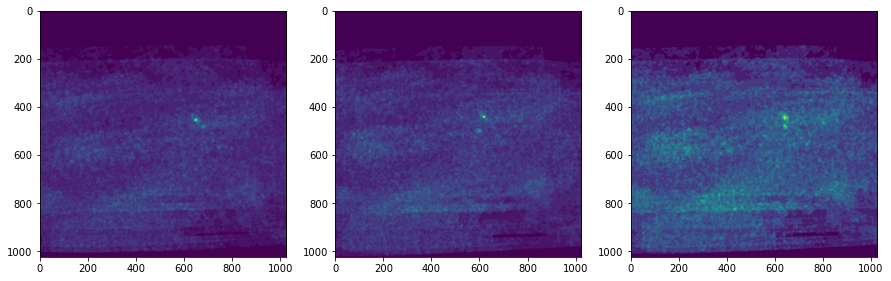

In [29]:
print(all_np_masks[10].max())

fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(131)
ax1.imshow(all_np_masks[0])

ax2 = fig.add_subplot(132)
ax2.imshow(all_np_masks[20],)

ax3 = fig.add_subplot(133)
ax3.imshow(all_np_masks[10],)

## Current Area

(11, 7, 1024, 1024)
(11, 49, 1024, 1024)
(11, 1024, 1024)


'\nfig = plt.figure(figsize=(25,20))\nax1 = fig.add_subplot(171)\nax1.imshow(temp)\nax2 = fig.add_subplot(172)\nax2.imshow(all_np_masks[1])\nax3 = fig.add_subplot(173)\nax3.imshow(all_np_masks[2])\nax4 = fig.add_subplot(174)\nax4.imshow(all_np_masks[3])\nax5 = fig.add_subplot(175)\nax5.imshow(all_np_masks[4])\nax6 = fig.add_subplot(176)\nax6.imshow(all_np_masks[5])\nax7 = fig.add_subplot(177)\nax7.imshow(all_np_masks[6])\n'

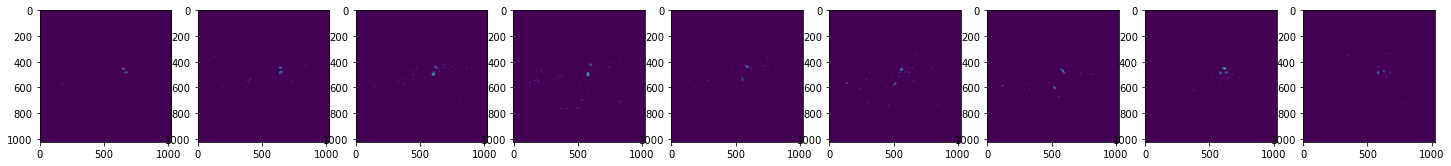

In [15]:
#img = cv2.bitwise_and(img,img,mask=mask) #apply the mask to remove the timestamp
def get_all_diffs(img_list):
    all_diffs = []

    for i in range(7):
        for j in range(7):
            temp = cv2.absdiff(img_list[i],img_list[j])
            all_diffs.append(temp)
    
    return all_diffs

all_np_mask_ = []

for i in range(11):
    all_np_mask_.append(all_np_masks[(i*7):(i*7+7)])

all_back_diffs = []

for i in range(len(all_np_mask_)):
    #print(len(all_np_mask_[i]))
    temp = get_all_diffs(all_np_mask_[i])
    all_back_diffs.append(temp)

print(np.array(all_np_mask_).shape)
print(np.array(all_back_diffs).shape)

all_backs = []

for i in range(len(all_back_diffs)):
    temp = get_background_mean(all_back_diffs[i])
    temp = cv2.bitwise_and(temp,temp,mask=cv2.cvtColor(all_image_masks[i*7+3], cv2.COLOR_BGR2GRAY))
    all_backs.append(temp)

#print(len(all_np_mask_))
#print(len(all_back_diffs))
#print(len(all_backs))
#print(np.array(all_backs).shape)

#display_images(all_np_masks,figsize=(11,7))
#display_images(other,figsize=(1,7))

final_images = []
for i in range(len(all_np_mask_)):
    temp = ((all_np_mask_[i][0]-all_backs[i])+(all_np_mask_[i][1]-all_backs[i])+(all_np_mask_[i][2]-all_backs[i])+(all_np_mask_[i][3]-all_backs[i])
                +(all_np_mask_[i][4]-all_backs[i])+(all_np_mask_[i][5]-all_backs[i])+(all_np_mask_[i][6]-all_backs[i]))
    final_images.append(temp)

print(np.array(final_images).shape)
#display_images(final_images)



fig = plt.figure(figsize=(25,15))
ax1 = fig.add_subplot(191)
ax1.imshow(all_backs[0])
ax2 = fig.add_subplot(192)
ax2.imshow(all_backs[1])
ax3 = fig.add_subplot(193)
ax3.imshow(all_backs[2])
ax4 = fig.add_subplot(194)
ax4.imshow(all_backs[3])
ax5 = fig.add_subplot(195)
ax5.imshow(all_backs[4])
ax6 = fig.add_subplot(196)
ax6.imshow(all_backs[5])
ax7 = fig.add_subplot(197)
ax7.imshow(all_backs[6])
ax8 = fig.add_subplot(198)
ax8.imshow(all_backs[7])
ax9 = fig.add_subplot(199)
ax9.imshow(all_backs[8])


"""
fig = plt.figure(figsize=(25,20))
ax1 = fig.add_subplot(171)
ax1.imshow(temp)
ax2 = fig.add_subplot(172)
ax2.imshow(all_np_masks[1])
ax3 = fig.add_subplot(173)
ax3.imshow(all_np_masks[2])
ax4 = fig.add_subplot(174)
ax4.imshow(all_np_masks[3])
ax5 = fig.add_subplot(175)
ax5.imshow(all_np_masks[4])
ax6 = fig.add_subplot(176)
ax6.imshow(all_np_masks[5])
ax7 = fig.add_subplot(177)
ax7.imshow(all_np_masks[6])
"""


In [16]:
#LOAD DATA
MASK = 'data/mask.png'
IMAGE_FOLDER = 'data_combined/validation'

all_validation_integrated=[]

for subdir, dirs, files in os.walk(IMAGE_FOLDER):
    for dir in dirs:
        img_path=os.path.join(subdir, dir)
        
        all_validation_integrated.append(read_images(img_path,MASK))
        
#making one big dict of dicts:
big_dic={}
for sample in all_validation_integrated:
    sample=sample[0]
    for key,value in sample.items():
        big_dic[key]=value
        
#we will only use the middle timeframes from now on an create an array for ease of use
val_middle_imgs=[]
img_key_list=[]
for key,value in big_dic.items():
    img_key_list.append(key)
    val_middle_imgs.append(value["3"]["3-int_image"])
val_middle_imgs=np.array(val_middle_imgs)

print(val_middle_imgs.shape)

(11, 1024, 1024, 3)


In [23]:
BBs=[]
for i in range(len(all_backs)):
    BBs.append(get_bounding_boxes(cv2.medianBlur(all_backs[i],3)))


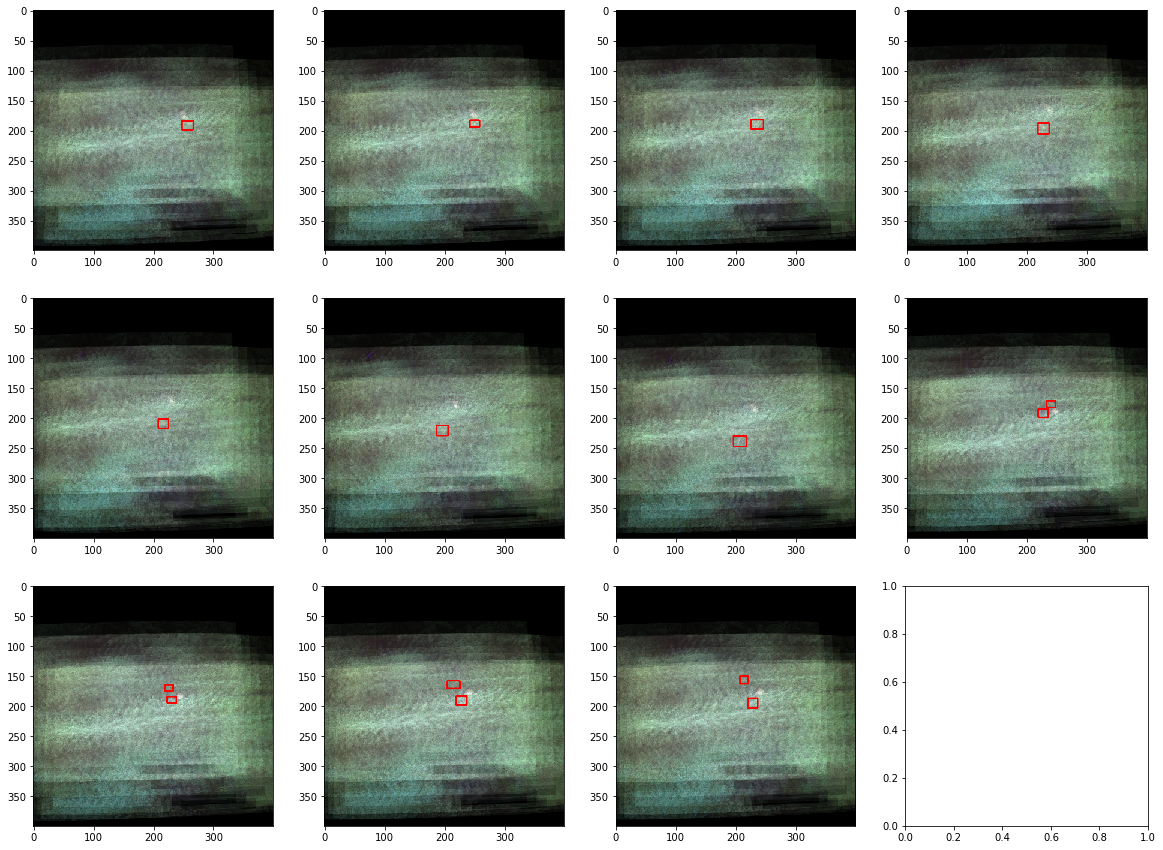

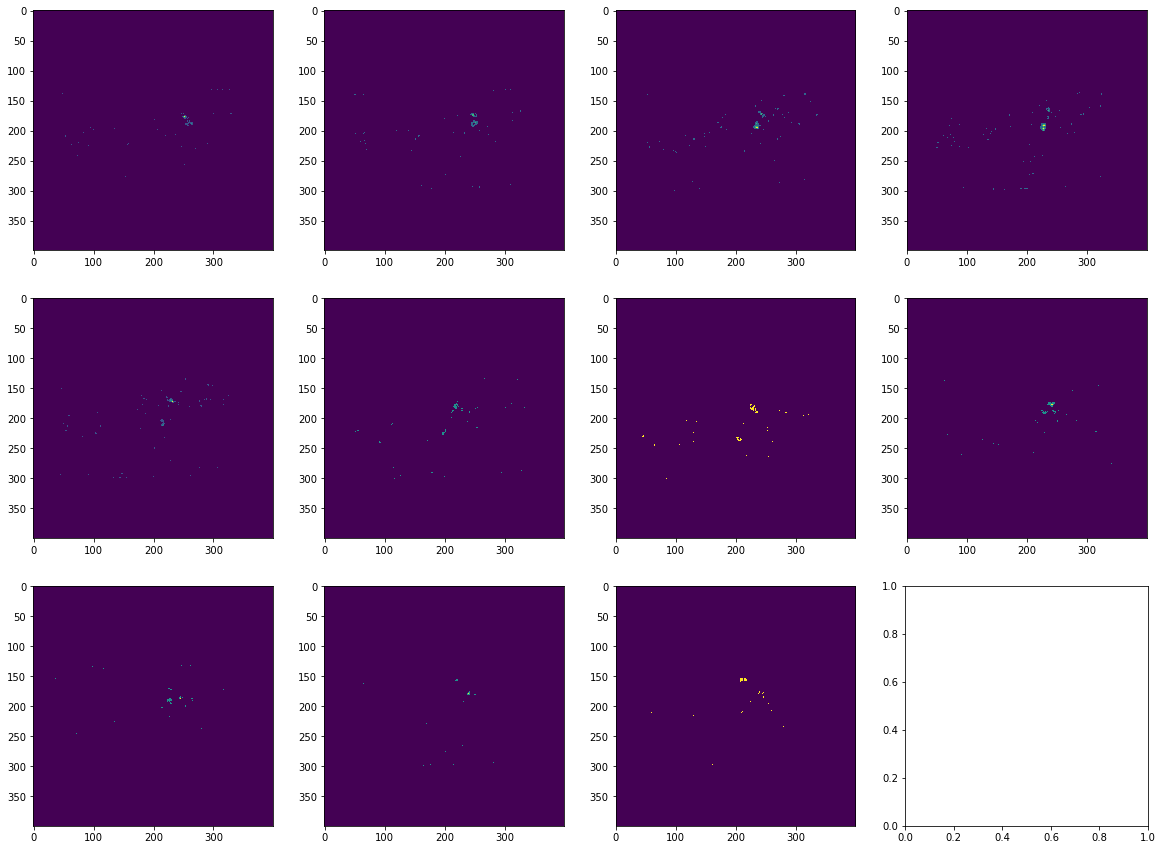

In [24]:
with open('data/validation/labels.json', 'r') as label_file:
    labels=json.load(label_file)

images_result = []
BBs_ = []
#print(BBs)
for z in range(len(BBs)):
    #print(BBs[z][0])
    tmp = val_middle_imgs[z].copy()
    add_bounding_boxes(tmp, BBs[z][0].tolist())
    BBs_.append(BBs[z][0])
    images_result.append(add_bounding_boxes(tmp, labels[img_key_list[z]], rgb_color = (255, 0, 0)))
    
display_images(np.array(images_result), figsize=(3,4), resize_dim=(400,400))
display_images(np.array(all_backs), figsize=(3,4), resize_dim=(400,400))

In [163]:
from evaluate import evaluate

with open('./data/validation/labels.json') as json_file:
    labels = json.load(json_file)

_BBs = []
for i in BBs_:
    _BBs.append(i.tolist())

#print(_BBs)
#print(img_key_list)
our_BBs={}
for i in range(len(img_key_list)):
    our_BBs[img_key_list[i]]=_BBs[i]

#print("")
print(our_BBs)
result = ut.compute_AP(our_BBs,labels)
print("")
print("")
print(result)

{'valid-2-0': [[594, 438, 40, 29], [559, 474, 42, 35]], 'valid-2-3': [[528, 384, 35, 33], [561, 478, 43, 42]], 'valid-1-4': [[534, 515, 44, 40]], 'valid-2-2': [[526, 404, 53, 33], [564, 469, 45, 39]], 'valid-1-6': [[501, 587, 55, 45]], 'valid-1-5': [[479, 544, 50, 42]], 'valid-1-2': [[575, 468, 54, 40]], 'valid-1-0': [[635, 473, 48, 37]], 'valid-1-3': [[558, 482, 48, 46]], 'valid-2-1': [[561, 420, 36, 29], [572, 471, 39, 27]], 'valid-1-1': [[622, 470, 41, 29]]}
{'valid-1-0': [[650, 471, 35, 24], [638, 448, 22, 20]], 'valid-1-1': [[626, 471, 33, 28], [631, 438, 23, 19]], 'valid-1-2': [[586, 474, 30, 37], [603, 431, 36, 30]], 'valid-1-3': [[567, 482, 27, 34], [591, 415, 22, 21]], 'valid-1-4': [[543, 517, 20, 34], [574, 424, 35, 24]], 'valid-1-5': [[501, 566, 14, 17], [549, 451, 20, 22]], 'valid-1-6': [[512, 591, 25, 21], [586, 459, 12, 26]], 'valid-2-0': [[574, 476, 23, 21], [599, 443, 32, 22]], 'valid-2-1': [[573, 475, 19, 19]], 'valid-2-2': [], 'valid-2-3': [[528, 393, 32, 16]]}


0.27

In [20]:
MASK = 'data/mask.png'
IMAGE_FOLDER = 'data_combined/validation/valid-1-0/'
BB_LABELS_FOLDER = 'data/validation/valid-1-0/'

mask = cv2.imread(MASK,0)
#homographies = json.loads(open(IMAGE_FOLDER+'homographies.json','r').read())

integrated_images = []
mask_images = []
anomaly_masks = []

for root, dirs, files in os.walk(IMAGE_FOLDER):
    for file in files:
        if 'int_image' in file:
            integrated_images.append(cv2.imread(os.path.join(root,file)))
        elif 'mask_image' in file:
            mask_images.append(cv2.imread(os.path.join(root,file)))
        elif 'anomaly_mask' in file:
            anomaly_masks.append(cv2.imread(os.path.join(root,file)))

#display_images(np.array(integrated_images), figsize=(1,7), resize_dim=(200,200))
#display_images(np.array(mask_images), figsize=(1,7), resize_dim=(200,200))
#display_images(np.array(anomaly_masks), figsize=(1,7), resize_dim=(200,200))

with open(os.path.join(BB_LABELS_FOLDER, 'labels.json'), 'r') as label_file:
    gtlabels = json.load(label_file)

with_valid_labels = []
with_our_labels = []
"""
for i in range(len(integrated_images)):
    with_valid_bbs = add_bounding_boxes(integrated_images[i],gtlabels)
    with_valid_labels.append(with_valid_bbs)

    our_bbs, thing = get_bounding_boxes(cv2.cvtColor(anomaly_masks[i],cv2.COLOR_BGR2GRAY),mask_images[i])
    with_our_bbs = add_bounding_boxes(integrated_images[i],our_bbs.tolist(),rgb_color=(255,0,0))
    with_our_labels.append(with_our_bbs)

    #fig = plt.figure(figsize=(15,7))
    #ax1 = fig.add_subplot(121)
    #ax1.imshow(with_valid_bbs)
    #ax1.title.set_text("Integrated Image BBs")
"""

for i in range(len(integrated_images)-1):
    im1 = cv2.cvtColor(integrated_images[i], cv2.COLOR_BGR2GRAY)
    im2 = cv2.cvtColor(integrated_images[i+1], cv2.COLOR_BGR2GRAY)

## Save Integrated Images, Anomaly Masks, etc.

Run the following section only if you have a lot of time :^)

In [18]:
MASK = 'data/mask.png'
IMAGE_FOLDER = 'data_combined/test/'

mask = cv2.imread(MASK,0)

orig_images_, warped_images_ = read_images(IMAGE_FOLDER, mask)

for i,y in orig_images_.items():
    print(i)


test-1-10
test-1-11
test-1-12
test-1-13
test-1-14
test-1-7
test-1-8
test-1-9
test-2-4
test-2-5
test-2-6
test-2-7
test-2-8


In [15]:
def integrate_and_save(warped_images: Dict[str, Dict[str, Dict[str, np.ndarray]]], target_dir: str) -> None:
    """
    Takes the loaded and warped images, integrates the different camera views and saves the
    integrated images in the provided directory.
    Folder structure already has to be present!

    Args:
        warped_images: Warped images from the read_images function.
        target_dir: Directory where the integrated images + integration mask should be saved

    Returns:
        None
    """
    img_lists = {}

    for img_set, time_step_dict in warped_images.items():
        img_lists[img_set] = []
        for time_step, n_camera_dict in time_step_dict.items():
            images = []
            for cam, img in n_camera_dict.items():
                images.append(img)
            img_lists[img_set].append(np.array(images))


    for folder, list in img_lists.items():
        if len(os.listdir(os.path.join(target_dir, folder))) > 0:
            continue
        start = time()
        print(folder)
        int_images, mask_images = integrate(list)
        for i, (int, mas) in enumerate(zip(int_images, mask_images)):
            cv2.imwrite(os.path.join(target_dir, folder, f'{i}-int_image.png'), int)
            cv2.imwrite(os.path.join(target_dir, "train", folder, f'{i}-mask_image.png'), mas * 255)
        print(f"Time it took to integrate images from {folder}: {strftime('%H:%M:%S', gmtime(time()-start))}")

In [19]:
for folder, time_step_dict in orig_images_.items():
    for time_step, img_dict in time_step_dict.items():
        for _, img in img_dict.items():
            start = time()
            reducing = ResidualAnomaly(img=img)
            red_mask = reducing.anomaly_mask()
            cv2.imwrite(os.path.join("data_combined", "test", folder, f'{time_step}-anomaly_mask.png'), red_mask * 255)
            print(f"It took {strftime('%H:%M:%S', gmtime(time()-start))}")

It took 00:04:43
It took 00:04:28
It took 00:04:28
It took 00:04:31
It took 00:04:30
It took 00:04:31
It took 00:04:33
It took 00:04:38
It took 00:04:38
It took 00:04:38
It took 00:04:40
It took 00:04:41
It took 00:04:39
It took 00:04:40
It took 00:04:38
It took 00:04:33
It took 00:04:33
It took 00:04:31
It took 00:04:39
It took 00:04:41
It took 00:04:40
It took 00:04:36
It took 00:04:39
It took 00:04:40
It took 00:04:41
It took 00:04:41
It took 00:04:41
It took 00:04:41
It took 00:04:40
It took 00:04:41
It took 00:04:43
It took 00:04:42
It took 00:04:41
It took 00:04:42
It took 00:04:41
It took 00:04:42
It took 00:04:41
It took 00:04:40
It took 00:04:41
It took 00:04:43
It took 00:04:41
It took 00:04:43
It took 00:04:40
It took 00:04:41
It took 00:04:41
It took 00:04:39
It took 00:04:42
It took 00:04:37
It took 00:04:41
It took 00:04:40
It took 00:04:42
It took 00:04:41
It took 00:04:40
It took 00:04:40
It took 00:04:40
It took 00:04:39
It took 00:04:14
It took 00:04:13
It took 00:04:

In [25]:
def calculate_anomaly_mask(
        img: np.ndarray,
        overlapping_mask: np.ndarray,
        filter_size: int,
        stride: int,
        number_k: int
):
    """
    Calculate the anomaly masks with the Residual approach in a more efficient way
    by cropping only the center part where all cameras are overlapping. This info
    is provided by the overlapping mask which has to be computed beforehand.

    Args:
        img: Integrated image of which the anomaly mask should be computed
        overlapping_mask: 2D-array which indicates the area of the img which is part of all 10 camera views
        filter_size: Size of the filter used to create patches in the Residual anomaly detection
        stride: Number of pixels the filter should move forward
        number_k: Number of neighbours which should be used for the knn algorithm

    Returns:
        An anomaly mask with the size of the original image,
        only showing anomalies where all camera views overlap
    """
    # get the coordinates of the mask for overlapping images
    non_zero_x, non_zero_y = np.nonzero(overlapping_mask)
    idx = [non_zero_x.min(), non_zero_x.max(), non_zero_y.min(), non_zero_y.max()]
    print(idx)

    # copy og image and select only the relevant center
    img_cp = img.copy()
    img_cp = img_cp[idx[0]: idx[1], idx[2]: idx[3], :]

    # start anomaly detection with the cropped image
    reducing = ResidualAnomaly(
        img=img_cp,
        filter_size=filter_size,
        stride=stride,
        number_k=number_k
    )
    red_mask = reducing.anomaly_mask()

    # pad the resulting anomaly mask to fit the cropped image if necessary
    h_img, w_img, _ = img_cp.shape
    h_mask, w_mask = red_mask.shape
    if not h_img == h_mask or not w_img == w_mask:
        h_pad = (h_img - h_mask)
        w_pad = (w_img - w_mask)
        red_mask = np.pad(
            red_mask,
            pad_width=((h_pad // 2, h_pad // 2 + h_pad % 2), (w_pad // 2, w_pad // 2 + w_pad % 2)),
            mode='constant'
        )

    # create anomaly mask with original image dimensions and add the calculated region
    red_mask_ = np.zeros((img.shape[0], img.shape[1]))
    red_mask_[idx[0]: idx[1], idx[2]: idx[3]] = red_mask

    return  red_mask_

In [52]:
"""calculate and save anomaly masks"""
for folder, time_step_dict in orig_images_.items():
    for time_step, img_dict in time_step_dict.items():
        for i, img in img_dict.items():
            start = time()

            # TODO: check the parameters here, could also use filter_size=3 and stride=2
            red_mask_ = calculate_anomaly_mask(
                img=img,
                overlapping_mask=masks[folder][time_step][f"{time_step}-mask_image"][:, :, 0],
                filter_size=5,
                stride=3,
                number_k=5
            )

            # save newly created anomaly mask as np array
            # TODO: change "validation" folder if necessary
            np.savez(os.path.join("numpy_masks", "validation", folder, f"{time_step}-anomaly_array.npz"), red_mask_)
            print(f"It took {strftime('%H:%M:%S', gmtime(time()-start))}")

In [10]:
test_img = orig_images_['valid-1-0']['5']['5-int_image']
test_mask = masks['valid-1-0']['5']['5-mask_image']

an_masks = []

for par in [
    (3, 2, 5), (5, 3, 5), (7, 3, 5), (15, 3, 5),
    (3, 2, 5), (5, 5, 5), (7, 5, 5), (15, 5, 5),
    (3, 2, 9), (5, 3, 9), (7, 3, 9), (15, 3, 9),
]:
    red_mask_ = calculate_anomaly_mask(
        img=test_img,
        overlapping_mask=test_mask[:, :, 0],
        filter_size=par[0],
        stride=par[1],
        number_k=par[2]
    )

    an_masks.append(red_mask_)

### Note on findings
Here different parameters for the anomaly detetions were tested. <br>
From left to right, the `filter_size` was increased from 3, to 5, 7 and 15. In the second row, the `stride` parameter was increased from 3 to 5 (where possible -> need overlapping patches). and the last row shows the effect of changing the number `k` for the knn-algorithm from 5 to 9.

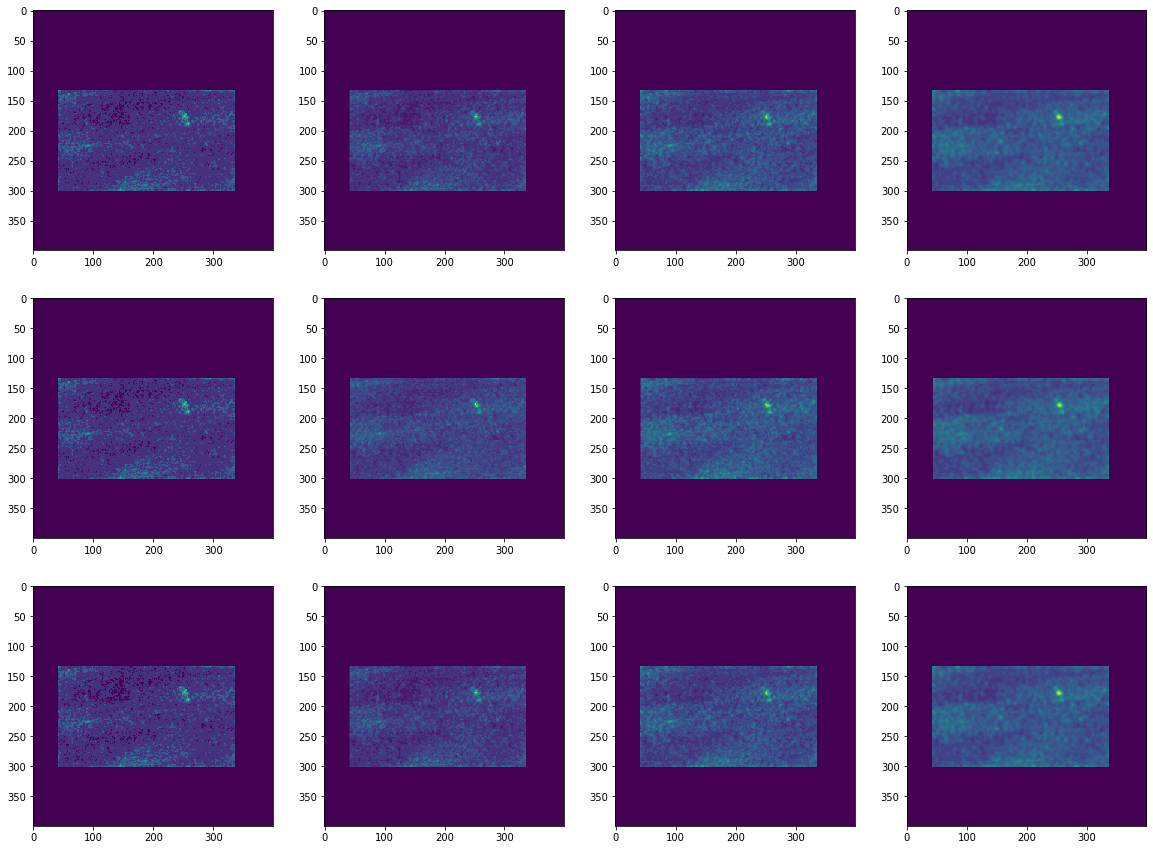

In [11]:
display_images(np.array(an_masks), figsize=(3,4), resize_dim=(400,400))